In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
import sys
import platform

# To solve windows linux path problems 
if platform.system() == 'Windows': 
    sys.path.append('C:/Users/naco1/OneDrive/Documentos/GitHub/Event_Star_tracker/lib')
from lib import utils

      TYC1  TYC2  TYC3   VTmag  HIP    RA(ICRS)   DE(ICRS)    recno
0        2   500     1  13.158  NaN    3.100781   2.274424      230
1        5    22     1  13.380  NaN    3.460134   3.072976      706
2        5   556     1  13.204  NaN    2.958764   4.755540      798
3        6    16     1  13.925  NaN    5.024723   4.314557      877
4        6    88     1  13.096  NaN    6.822331   4.203394      885
...    ...   ...   ...     ...  ...         ...        ...      ...
9920  9527  2156     1  13.285  NaN  290.069599 -84.793113  2538602
9921  9532   411     1  13.161  NaN  314.378316 -86.610253  2539436
9922  9533   766     1  13.205  NaN  351.892780 -86.404470  2539621
9923  9533   806     1  13.148  NaN  352.993701 -87.111313  2539625
9924  9535   215     1  13.364  NaN  277.143004 -88.731150  2539783

[9925 rows x 8 columns]
Data shape:  (9925, 3)
Star ID:  0.0 , lat: 3.10078139 , len:  2.27442444
Star ID:  1.0 , lat: 3.46013417 , len:  3.07297556
Star ID:  2.0 , lat: 2.95876389 , 

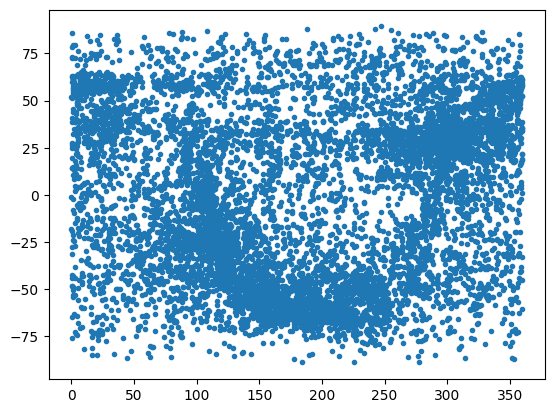

In [11]:

## Select the dataset type: 'random' or 'tycho'
# stars_data = utils.get_star_dataset(type ='random', n_stars = 4000)
stars_data = utils.get_star_dataset(type ='tycho', path = 'data/vizier_I_259_tyc2_20231202_2.csv')

print(stars_data)

# If data type is a dataframe from a catalog transform it to array
if isinstance(stars_data, pd.DataFrame):
    stars_data['data_number'] = stars_data.index
    stars_data = stars_data[['data_number','RA(ICRS)', 'DE(ICRS)']].values

print("Data shape: ", stars_data.shape)

for i in range(5):
    print("Star ID: ", stars_data[i][0], ", lat:", stars_data[i][1], ", len: ", stars_data[i][2])

plt.figure()
plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')
plt.show()

In [14]:
from scipy.spatial import KDTree

# Create the k-d tree to find the nearest neighborhoods of the center stars
# As this is used only for the training of the SOM performace is not needed
tree = KDTree(stars_data[:,:2])

n_of_neighbor = 4 # Number of neighborhoods stars used to compute the features

# Find the 5 closest neighbors for each star
distances, indices = tree.query(stars_data[:,:2], k=n_of_neighbor+1)

#Initialice the dual SOM features vector
features_vec_1 = []
features_vec_2 = []
features_vec_3 = []


# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):
    print("Star ID:", stars_data[i][0], "(","%0.2f" % stars_data[i][1],",","%0.2f" %stars_data[i][2],")")

    # Initialice the subsets of features
    features_1 = []
    features_2 = []
    features_3 = []


    for j in range(1,n_of_neighbor+1):
        neighbor_index = indices[i][j]
        x_distance = stars_data[neighbor_index][1] - stars_data[i][1]
        y_distance = stars_data[neighbor_index][2] - stars_data[i][2]
        print("Neighbor ID:", stars_data[neighbor_index][0], "(","%0.2f" %stars_data[neighbor_index][1],",","%0.2f" %stars_data[neighbor_index][2],")", ", x-distance:", x_distance, ", y-distance:", y_distance)

        #  Define the features vector that is going to be used in the SOM:
        # TODO: Try diferent combinations of features to set the most efective one

        # features = [ x1-x2, y1-y2, x1-x3, y1-y3, ..., x1-x_n, y1-y_n]
        features_1.append(x_distance)
        features_1.append(y_distance)

        # fetaures = [ r1 * r2, r1*r3, r1*r_n]
        # features_2.append(stars_data[neighbor_index][0] * stars_data[i][0]
        #                 + stars_data[neighbor_index][1] * stars_data[i][1]) 

        # Inter neighbor features
        # features = [ x2-x3, y2-y3, x2-x4, y2-y4, ..., x_m-x_n, y_m-y_n]
        # for k in range(1 +j-1,n_of_neighbor+1):
        #     features_2.append((stars_data[indices[i][k]][1] - stars_data[indices[i][j-1]][1])
        #                     *(stars_data[indices[i][k]][2] - stars_data[indices[i][j-1]][2])
        #                     )
            
        for k in range(1 +j-1,n_of_neighbor+1):
            features_2.append( np.sqrt( (stars_data[indices[i][k]][1] - stars_data[indices[i][j-1]][1])**2
                            +(stars_data[indices[i][k]][2] - stars_data[indices[i][j-1]][2])**2 )
                            )       

    features_vec_1.append(features_1)
    features_vec_2.append(features_2)
    # features_vec_3.append(features_3)


    print("Number of features: ", len(features_vec_1[0]),",",len(features_vec_2[0]) )

Star ID: 0.0 ( 3.10 , 2.27 )
Neighbor ID: 1.0 ( 3.46 , 3.07 ) , x-distance: 0.35935278000000004 , y-distance: 0.79855112
Neighbor ID: 2.0 ( 2.96 , 4.76 ) , x-distance: -0.14201749999999969 , y-distance: 2.4811158399999997
Neighbor ID: 3.0 ( 5.02 , 4.31 ) , x-distance: 1.9239419399999997 , y-distance: 2.04013278
Neighbor ID: 4.0 ( 6.82 , 4.20 ) , x-distance: 3.7215494400000004 , y-distance: 1.92897
Number of features:  8 , 10
Star ID: 1.0 ( 3.46 , 3.07 )
Neighbor ID: 0.0 ( 3.10 , 2.27 ) , x-distance: -0.35935278000000004 , y-distance: -0.79855112
Neighbor ID: 2.0 ( 2.96 , 4.76 ) , x-distance: -0.5013702799999997 , y-distance: 1.6825647199999998
Neighbor ID: 3.0 ( 5.02 , 4.31 ) , x-distance: 1.5645891599999997 , y-distance: 1.24158166
Neighbor ID: 4.0 ( 6.82 , 4.20 ) , x-distance: 3.3621966600000004 , y-distance: 1.1304188800000001
Number of features:  8 , 10
Star ID: 2.0 ( 2.96 , 4.76 )
Neighbor ID: 1.0 ( 3.46 , 3.07 ) , x-distance: 0.5013702799999997 , y-distance: -1.6825647199999998
N

In [16]:

features_vec_1 = np.array(features_vec_1)
features_vec_2 = np.array(features_vec_2)

# Normalize the data -> better performace of the SOM 
def normalize_features(star_features):
    star_features_normalized = (star_features - star_features.min(axis=0)) / (star_features.max(axis=0) - star_features.min(axis=0))
    return star_features_normalized

features_1_n = normalize_features(np.array(features_vec_1))
features_2_n = normalize_features(np.array(features_vec_2))

# Must be more neurons that points -> sqrt of data size to set the mesh: data < som_rows * som_cols
# mesh_size = int(np.sqrt(features_1_n.shape[0])/2)
# Manual set 
mesh_size = 60

# Initialize the SOM
som1 = MiniSom(
    x = mesh_size,
    y = mesh_size,
    input_len = features_1_n.shape[1],
    sigma=2.0,
    learning_rate=0.7,
    neighborhood_function='gaussian',
)
print(f"SOM size = {mesh_size} x {mesh_size}")
som2 = MiniSom(
    x = mesh_size,
    y = mesh_size,
    input_len = features_2_n.shape[1],
    sigma=2.0,
    learning_rate=0.7,
    neighborhood_function='gaussian',
)
print(f"SOM size = {mesh_size} x {mesh_size}")

# Train the SOM
som1.train_random(data=features_1_n, num_iteration=1000000, verbose= True)
som2.train_random(data=features_2_n, num_iteration=1000000, verbose= True)


SOM size = 60 x 60
SOM size = 60 x 60
 [ 1000000 / 1000000 ] 100% - 0:00:00 left 
 quantization error: 0.01573113299631262
 [ 1000000 / 1000000 ] 100% - 0:00:00 left 
 quantization error: 0.01687682917602638


In [17]:
# Check that neurons correspond to a star, the rest of the neurons don't have any star ID set,
#  this also imply that there are some neurons with more than one star parameters stored 

# Another dict for map neurons to star (just to check), same as star_ids but created from som.winner rather than som.winner_map
def add_values_in_dict(sample_dict, key, list_of_values):
    ''' Append multiple values to a key in 
        the given dictionary '''
    if key not in sample_dict:
        sample_dict[key] = list()
    sample_dict[key].extend(list_of_values)
    return sample_dict

star_dict_1= {}
star_dict_2= {}

for i in range(len(features_1_n)):
    star_dict_1 = add_values_in_dict(star_dict_1, som1.winner(features_1_n[i]),[i])
    star_dict_2 = add_values_in_dict(star_dict_2, som2.winner(features_2_n[i]),[i])


print("Number of neurons with data:",len(star_dict_1),"; Total neurons:", som1._xx.shape[0]*som1._xx.shape[1])
print("Number of neurons with data:",len(star_dict_2),"; Total neurons:", som2._xx.shape[0]*som2._xx.shape[1])
star_dict_1

Number of neurons with data: 3427 ; Total neurons: 3600
Number of neurons with data: 3388 ; Total neurons: 3600


{(46, 45): [0],
 (45, 38): [1],
 (11, 26): [2, 402, 2982, 3044, 5488],
 (19, 44): [3],
 (5, 25): [4, 70, 318, 446, 800],
 (1, 58): [5, 4781],
 (36, 55): [6, 1467, 5359],
 (53, 42): [7, 194],
 (19, 4): [8, 2757, 8951, 8952, 9816],
 (42, 56): [9],
 (22, 33): [10, 289, 1289, 3581],
 (19, 0): [11, 702, 2917],
 (58, 8): [12, 373, 977, 4335, 5325],
 (51, 7): [13, 144, 1506, 9431],
 (26, 32): [14, 6487],
 (44, 51): [15],
 (17, 1): [16, 3394, 4816, 5046],
 (4, 37): [17, 829],
 (38, 56): [18, 6624],
 (46, 17): [19, 4848, 7064],
 (36, 2): [20, 928],
 (59, 52): [21, 2279, 3351, 6504, 7670],
 (8, 47): [22, 23, 8306],
 (7, 59): [24, 7650],
 (43, 18): [25, 9861],
 (47, 41): [26, 6716],
 (48, 55): [27, 4817, 5084, 5863],
 (22, 37): [28, 5173, 6618],
 (8, 43): [29, 5115, 5481, 9746],
 (1, 47): [30, 3395, 7195],
 (59, 44): [31, 200, 240, 1330, 5079],
 (41, 51): [32, 1315],
 (21, 34): [33, 1416, 3931, 5489],
 (20, 0): [34],
 (52, 3): [35, 3100, 4373],
 (9, 42): [36],
 (0, 11): [37, 2232, 2323],
 (57, 50

SOM1: Predicted Stars ID: [3219, 5514]
SOM2: Predicted Stars ID: [1305, 4280, 5514, 6714, 8962]
Final guess: 5514, actual star ID: 5514


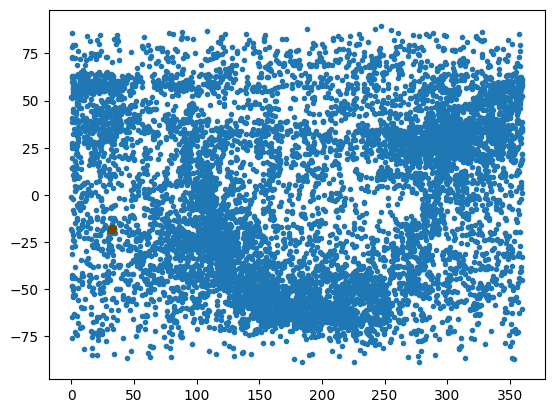

In [21]:
# Define a function to predict the star ID for a given feature vector
def predict_star_id(features, features_array, dictionary, som):
    normalized_feature = (features - features_array.min(axis=0)) / (features_array.max(axis=0) - features_array.min(axis=0))
    winner = som.winner(normalized_feature)
    if winner in dictionary:
        return dictionary[winner]
    else:
        return [0] #The neuron has no star ID return [0], the ID start at 1 
    
# Test the prediction for a sample feature vector
random_id = np.random.randint(0,len(features_vec_1))

sample_feature_1= features_vec_1[random_id] 
sample_feature_2= features_vec_2[random_id] 

predicted_star_ids_1 = predict_star_id(sample_feature_1,np.array(features_vec_1),star_dict_1,som1)
predicted_star_ids_2 = predict_star_id(sample_feature_2,np.array(features_vec_2),star_dict_2,som2)

if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) < 2:
    star_guess = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))[0]

print(f"SOM1: Predicted Stars ID: {predicted_star_ids_1}")
print(f"SOM2: Predicted Stars ID: {predicted_star_ids_2}" )
print(f"Final guess: {star_guess}, actual star ID: {random_id}")

plt.figure()
plt.plot(stars_data[:,1],stars_data[:,2],'.')
plt.plot(stars_data[random_id][1],stars_data[random_id][2],'og')
plt.plot(stars_data[star_guess][1],stars_data[star_guess][2],'xr')
plt.show()


In [73]:

cont = np.zeros(3) # [Correct match, miss match, multiple match]
mean_noise = 0
for i in range(features_vec_1.shape[0]):

    # Itroduce noise in the features vector to check the response of the SOM
    scale = 0.05 # % respect max value 

    noise_1 = np.random.normal(loc=0, scale=1, size=features_vec_1.shape[1])*np.max(features_vec_1[i])*scale
    noise_2 = np.random.normal(loc=0, scale=1, size=features_vec_2.shape[1])*np.max(features_vec_2[i])*scale
    sample_feature_1= features_vec_1[i] - noise_1
    sample_feature_2= features_vec_2[i] - noise_2

    mean_noise += np.mean( np.abs(noise_1)/features_vec_1[i] ) + np.mean( np.abs(noise_2)/features_vec_2[i] ) 

    predicted_star_ids_1 = predict_star_id(sample_feature_1,np.array(features_vec_1),star_dict_1,som1)
    predicted_star_ids_2 = predict_star_id(sample_feature_2,np.array(features_vec_2),star_dict_2,som2)

    star_guess = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))
    if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) == 1:
        cont[0] += star_guess[0] == i
    else:
        # print("Error: ", list(set(predicted_star_ids_1).intersection(predicted_star_ids_2)), "!=", i)
        cont[1] += len(star_guess) == 0
        cont[2] += len(star_guess) > 1
mean_noise = mean_noise / features_vec_1.shape[0] / 2
print("mean noise level=",  mean_noise)
print("total succes =",  cont / features_vec_1.shape[0])

mean noise level= 0.0490161592228606
total succes = [0.58448363 0.34962217 0.05178841]
